In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random


In [2]:
def f(x):
  return 3*x**2 - 4*x + 5 # Defining a mathematical expression

In [3]:
f(3)

20

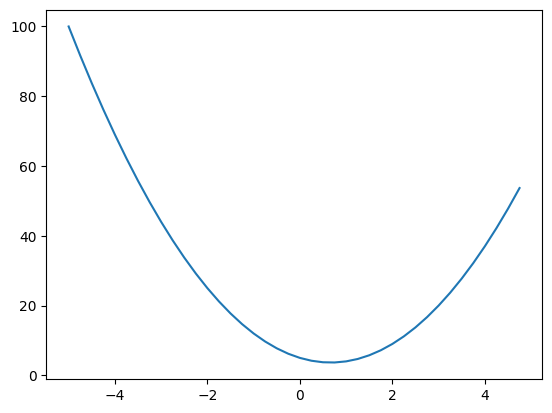

In [4]:
xs = np.arange(-5, 5, 0.25) # A list from -5 to 5 (not including 5), in steps of 0.25.
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# calculating the slope

h = 0.000001 # a very small amount
x = 3
(f(x + h) - f(x))/h

14.000003002223593

In [6]:
# a little bit more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c

print(d)

4.0


In [7]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # how much "d1" changes in respect to "a" (dd/da = -3, (-3x+10)' = -3)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [8]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
  
    out._backward = _backward
    
    return out

  def __radd__(self, other):
    return self + other # reverse other so it uses __add__

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):
    return self * other # reverse other so it uses __mul__
  
  def __truediv__(self, other): # self / other
    return self * other**-1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int or float for now"

    out = Value(self.data**other, (self, ), f"**{other}")

    def _backward():
      self.grad = other * self.data**(other - 1) * out.grad

    out._backward = _backward

    return out
  
  def __sub__(self, other):
    return self + (-other)
  
  def __neg__(self):
    return self * -1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward

    return out
  
  def backward(self):
    # Topological Sort
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        # loops through all the children
        for child in v._prev:
          build_topo(child)
        # adds itself after all the children had been processed
        topo.append(v)
    build_topo(self)

    self.grad = 1 # base case
    for node in reversed(topo):
      node._backward()
  
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


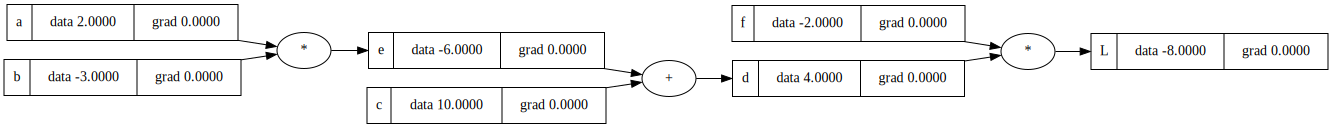

In [10]:
draw_dot(L)

In [11]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0

#a.data += 0.01 * a.grad
print(str(b.data) + " += 0.01 * " + str(b.grad) + " = " + str(b.data + 0.01 * b.grad))
#b.data += 0.01 * b.grad
#c.data += 0.01 * c.grad
#f.data += 0.01 * f.grad

# Changing (if we nudge) the data by the direction of the gradient, we expect a positive influence on L (the loss function)
# because if the gradient is positive, we want to increase the data, and if the gradient is negative, we want to decrease the data
# Example: L = -5x + 10
# Data: x = 2 
# -5(2) + 10 = 0 

# x = 1.95 (Nudging the data by the direction of the gradient: x += 0.01 * grad <=> x += 0.01 * -5 <=> x += -0.05 <=> x = 1.95)
# -5(1.95) + 10 = 0.25

# We can see that the loss function increased, which is what we expected

e = a * b
d = e + c
L = d * f

print(L.data)

-3.0 += 0.01 * -4.0 = -3.04
-8.0


In [12]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()


-3.9999999999995595


##### Manual backpropagation of a neuron

Mathematical model:

<img style="width: 500px" src="https://cs231n.github.io/assets/nn1/neuron_model.jpeg">

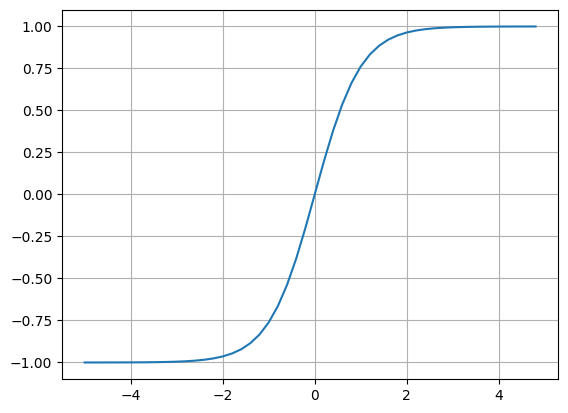

In [13]:
# activating function:
# tanh(x) = (e^x - e^-x) / (e^x + e^-x)
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#o = n.tanh(); # output of the neuron

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o' 
o

Value(data=0.7071067811865477)

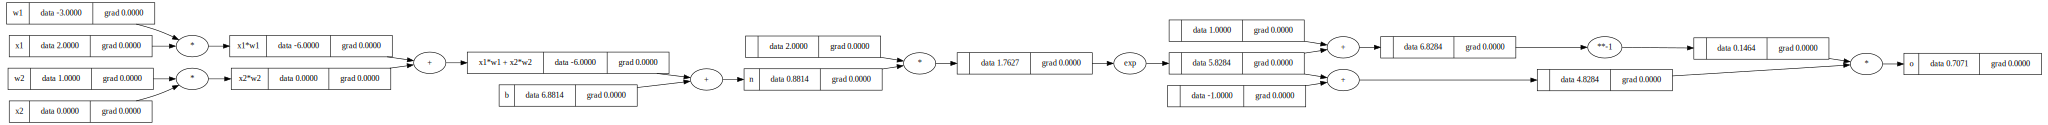

In [15]:
draw_dot(o)

In [16]:
o.grad = 1
o._backward()

In [17]:
n._backward()

In [18]:
b._backward()

In [19]:
x1w1x2w2._backward()

In [20]:
x1w1._backward()
x2w2._backward()

In [21]:
# Auto backward

o.grad = 1 # base case

# Topological Sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    # loops through all the children
    for child in v._prev:
      build_topo(child)
    # adds itself after all the children had been processed
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

In [22]:
o.backward()

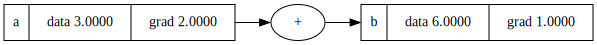

In [23]:
# Example

# Fix bug by accumulating grads (+=)

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)


In [24]:
a = Value(1)
b = Value(2)

a / b

Value(data=0.5)

##### Using pytorch

In [25]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('--- grads: ---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
--- grads: ---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [26]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

#### Building a NeuralNet (Multi-layer perceptron)

<img styles="width: 300px" src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="">

In [60]:
from typing import Any


class Neuron:

    def __init__(self, nin):
        # nin = number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # random weights from -1 to 1
        self.b = Value(random.uniform(-1, 1)) # random bias

    def __call__(self, x):
        # x = list with the data
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh() # activation function

        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # creates neurons

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # calls neurons with the data
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [114]:
x = [2.0, -1.0, 5.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5540709507516043)

In [116]:
xs = [
    [2.0, 8.0, -1.0],
    [6.0, -1.0, 0.5],
    [7.0, 2.0, -2.0],
    [1.0, -0.5, 3.0]
] # data
ys = [1.0, 1.0, -1.0, 1.0] # desired targets

In [237]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs] # passing the data through the MLP to get the predicted values
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # zero grad
    for p in n.parameters():
        p.grad = 0
    # backward pass
    loss.backward()

    # update
    learning_rate = 0.7

    for p in n.parameters():
        p.data += learning_rate * -p.grad

    print(k, loss.data)


0 0.00010515803072185491
1 0.00010485770966896517
2 0.00010455905856138565
3 0.00010426206363060026
4 0.0001039667112583452
5 0.00010367298797458843
6 0.0001033808804555074
7 0.0001030903755215179
8 0.00010280146013534359
9 0.0001025141214000825
10 0.00010222834655735612
11 0.00010194412298545077
12 0.00010166143819747658
13 0.00010138027983961232
14 0.00010110063568930838
15 0.00010082249365358667
16 0.00010054584176729486
17 0.00010027066819146448
18 9.99969612116277e-05
19 9.972470923620293e-05


In [ ]:
draw_dot(loss)

In [238]:
ypred

[Value(data=0.9950018068551334),
 Value(data=0.995323807137399),
 Value(data=-0.9928837182910462),
 Value(data=0.9985051657371535)]